<a href="https://colab.research.google.com/github/TonioHathos/AI_Valeo/blob/main/Code_Yudi/Trees_Mod%C3%A8le_Yudi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Livrarias

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import log_loss

from collections import Counter

from imblearn.over_sampling import SMOTE


# Import the visualization library I prepared for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from visualization import plot_conf_mat, plot_feature_importances


!pip install ipython-autotime # To show time at each cell
                              # Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
%load_ext autotime


# The following is to be able to mount Google Drive
from google.colab import drive

import pickle # To save the model
from os.path import isfile

# The following is to be able to mount Google Drive
from google.colab import drive

import os
from os.path import isfile
import datetime
import shutil
from functools import partial, partialmethod

--2023-06-18 19:49:33--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13023 (13K) [text/plain]
Saving to: ‘visualization.py.8’

visualization.py.8  100%[===================>]  12.72K  --.-KB/s    in 0s      

2023-06-18 19:49:33 (111 MB/s) - ‘visualization.py.8’ saved [13023/13023]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 4.32 s (started: 2023-06-18 19:49:33 +00:00)


#PreProcessing

In [65]:
! rm -f *.csv
! wget https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
df_training_mod = pd.read_csv('df_yudi.csv')



--2023-06-18 19:49:37--  https://raw.githubusercontent.com/TonioHathos/AI_Valeo/main/Code_Yudi/df_yudi.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3334811 (3.2M) [text/plain]
Saving to: ‘df_yudi.csv’

df_yudi.csv         100%[===================>]   3.18M  --.-KB/s    in 0.02s   

2023-06-18 19:49:37 (188 MB/s) - ‘df_yudi.csv’ saved [3334811/3334811]

time: 447 ms (started: 2023-06-18 19:49:37 +00:00)


In [66]:
varianciat = df_training_mod.var
varianciat()

Rodage_U                         9.299679e-06
V1_torque                        2.144256e-01
Rodage_I                         1.245047e+01
V2_torque                        2.125768e-01
SnapRingMidPointForce            4.675433e+01
Premier angle                    2.453186e+02
SnapRingPeakForce                1.270465e+02
Deuxième angle                   2.277531e+02
Vissage_M8_torque                4.266577e-03
Capuchon_insertion               2.484328e-01
StartLinePeakForce               6.483854e+00
Vissage_M8_angle_log             1.061920e-01
SnapRingFinalStroke_exp          2.863603e+09
Binar OP130_Resultat_Global_v    8.758903e-03
dtype: float64

time: 10.6 ms (started: 2023-06-18 19:49:37 +00:00)


In [67]:
cols_rm = ['Binar OP130_Resultat_Global_v'] + ['SnapRingFinalStroke_exp'] + ['Rodage_U'] + ['StartLinePeakForce'] + ['V1_torque'] + ['Capuchon_insertion'] + ['V2_torque']
cols_rm

['Binar OP130_Resultat_Global_v',
 'SnapRingFinalStroke_exp',
 'Rodage_U',
 'StartLinePeakForce',
 'V1_torque',
 'Capuchon_insertion',
 'V2_torque']

time: 24.6 ms (started: 2023-06-18 19:49:37 +00:00)


In [68]:
df_training_filtr = df_training_mod.drop(columns = cols_rm)

time: 4.12 ms (started: 2023-06-18 19:49:37 +00:00)


In [69]:
df_training_filtr.shape

(34515, 7)

time: 4.59 ms (started: 2023-06-18 19:49:37 +00:00)


In [108]:
X = df_training_mod.drop(columns = ['Binar OP130_Resultat_Global_v'])
y = df_training_mod['Binar OP130_Resultat_Global_v']

time: 2.21 ms (started: 2023-06-18 20:14:27 +00:00)


In [109]:
X_train, X_test, y_train, y_test =train_test_split(X ,y , test_size=0.3, shuffle=True, random_state=18)


time: 9.3 ms (started: 2023-06-18 20:14:30 +00:00)


In [110]:
smote = SMOTE()

X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    23933
1    23933
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 27.4 ms (started: 2023-06-18 20:14:31 +00:00)


#Training the model 1

In [111]:
model = RandomForestClassifier(n_estimators=200,
                      criterion='gini',
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model.fit(X_train_balanced, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', max_leaf_nodes=16, n_estimators=200,
                       n_jobs=-1, random_state=5)

time: 5.98 s (started: 2023-06-18 20:14:35 +00:00)


Normalized confusion matrix
[[0.78476209 0.21523791]
 [0.5        0.5       ]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

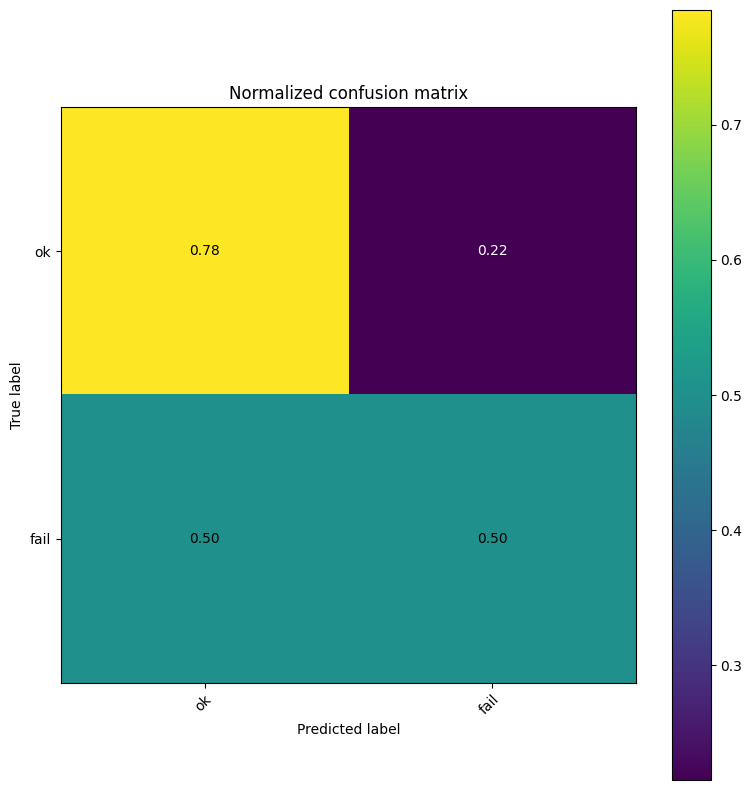

time: 604 ms (started: 2023-06-18 20:14:44 +00:00)


In [112]:
y_pred = model.predict(X_test)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)


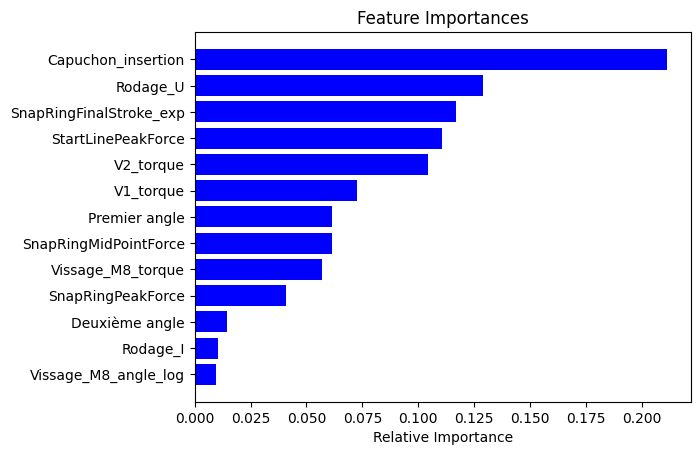

Index(['Rodage_U', 'V1_torque', 'Rodage_I', 'V2_torque',
       'SnapRingMidPointForce', 'Premier angle', 'SnapRingPeakForce',
       'Deuxième angle', 'Vissage_M8_torque', 'Capuchon_insertion',
       'StartLinePeakForce', 'Vissage_M8_angle_log',
       'SnapRingFinalStroke_exp'],
      dtype='object')

time: 251 ms (started: 2023-06-18 20:14:49 +00:00)


In [113]:
feature_names = X_test.columns
plot_feature_importances(model.feature_importances_, feature_names)
feature_names

# Trainin model 2

In [85]:
cols_md2 = ['SnapRingFinalStroke_exp'] + ['Rodage_U'] + ['StartLinePeakForce'] + ['V1_torque'] + ['Capuchon_insertion'] + ['V2_torque']


time: 461 µs (started: 2023-06-18 20:05:15 +00:00)


In [86]:
X2 = df_training_mod[cols_md2]

time: 2.82 ms (started: 2023-06-18 20:05:20 +00:00)


In [87]:
X_train, X_test, y_train, y_test =train_test_split(X2 ,y , test_size=0.3, shuffle=True, random_state=18)


time: 6.29 ms (started: 2023-06-18 20:05:21 +00:00)


In [88]:
smote = SMOTE()

X_train_balanced2, y_train_balanced2 = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    23933
1    23933
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 16.7 ms (started: 2023-06-18 20:05:23 +00:00)


In [102]:
model2 = RandomForestClassifier(n_estimators=200,
                      criterion='gini',
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model2.fit(X_train_balanced2, y_train_balanced2)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', max_leaf_nodes=16, n_estimators=200,
                       n_jobs=-1, random_state=5)

time: 2.43 s (started: 2023-06-18 20:11:57 +00:00)


Normalized confusion matrix
[[0.74700788 0.25299212]
 [0.46153846 0.53846154]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

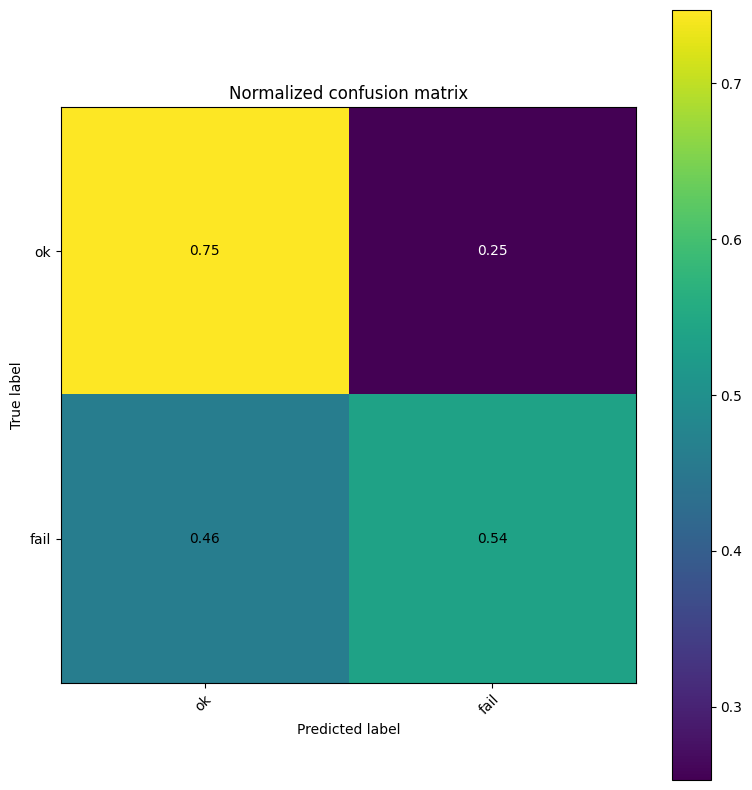

time: 363 ms (started: 2023-06-18 20:12:05 +00:00)


In [103]:
y_pred = model2.predict(X_test)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)

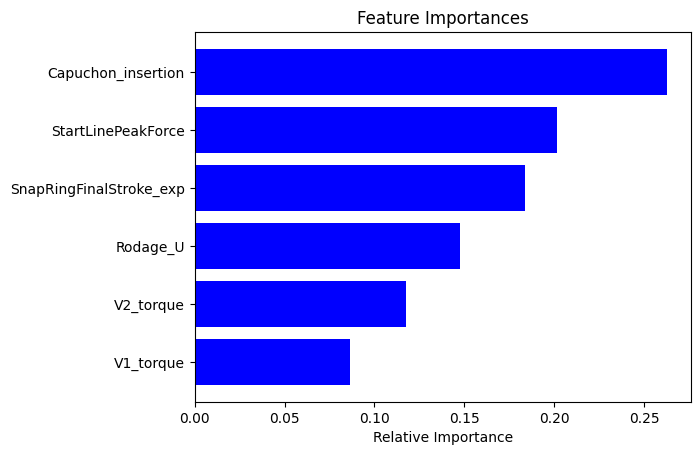

Index(['SnapRingFinalStroke_exp', 'Rodage_U', 'StartLinePeakForce',
       'V1_torque', 'Capuchon_insertion', 'V2_torque'],
      dtype='object')

time: 222 ms (started: 2023-06-18 20:12:18 +00:00)


In [104]:
feature_names = X_test.columns
plot_feature_importances(model2.feature_importances_, feature_names)
feature_names

#Training model 3

In [92]:
cols_md3 = ['SnapRingFinalStroke_exp'] + ['Rodage_U'] + ['StartLinePeakForce'] + ['Vissage_M8_torque'] + ['Capuchon_insertion'] + ['SnapRingMidPointForce'] + ['Premier angle']

time: 444 µs (started: 2023-06-18 20:09:24 +00:00)


In [93]:
X3 = df_training_mod[cols_md3]

time: 2.1 ms (started: 2023-06-18 20:10:09 +00:00)


In [94]:
X_train, X_test, y_train, y_test =train_test_split(X2 ,y , test_size=0.3, shuffle=True, random_state=18)


time: 8.02 ms (started: 2023-06-18 20:10:20 +00:00)


In [98]:
smote = SMOTE()

X_train_balanced3, y_train_balanced = smote.fit_resample(X_train, y_train)
pd.value_counts(y_train_balanced)

0    23933
1    23933
Name: Binar OP130_Resultat_Global_v, dtype: int64

time: 18.5 ms (started: 2023-06-18 20:11:17 +00:00)


In [105]:
model3 = RandomForestClassifier(n_estimators=200,
                      criterion='gini',
                      max_leaf_nodes=16, # Each tree cannot have more than that
                      random_state=5, # For reproducibility
                      n_jobs=-1, # Use all the CPUs
                      max_features = 'auto' # auto means=sqrt(n_features)
                      )

model3.fit(X_train_balanced3, y_train_balanced)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(max_features='auto', max_leaf_nodes=16, n_estimators=200,
                       n_jobs=-1, random_state=5)

time: 2.37 s (started: 2023-06-18 20:12:47 +00:00)


Normalized confusion matrix
[[0.76880413 0.23119587]
 [0.47435897 0.52564103]]


<Axes: title={'center': 'Normalized confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

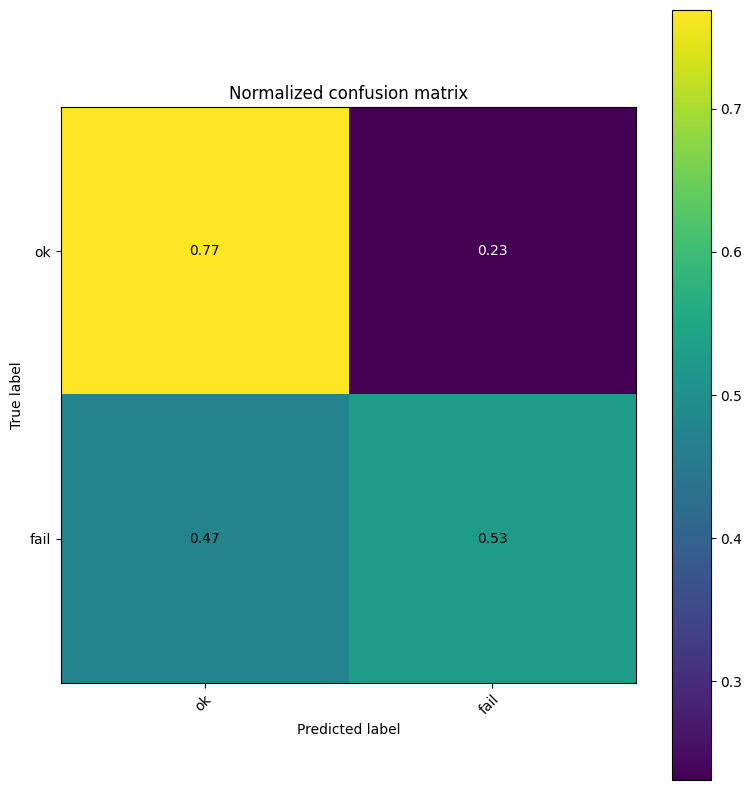

time: 407 ms (started: 2023-06-18 20:13:02 +00:00)


In [106]:
y_pred = model3.predict(X_test)

class_names = np.array(['ok', 'fail'])
plot_conf_mat(y_test, y_pred, class_names)

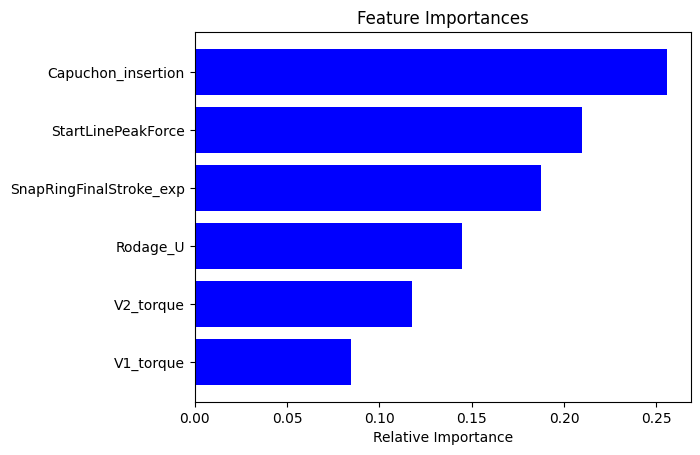

Index(['SnapRingFinalStroke_exp', 'Rodage_U', 'StartLinePeakForce',
       'V1_torque', 'Capuchon_insertion', 'V2_torque'],
      dtype='object')

time: 317 ms (started: 2023-06-18 20:13:21 +00:00)


In [107]:
feature_names = X_test.columns
plot_feature_importances(model3.feature_importances_, feature_names)
feature_names

#GridSearch

In [114]:
param_grid = {
    'criterion':['gini', 'entropy'],
    'max_features':[1,2,3,4,5],

    # Number of allowed leafs
    'max_leaf_nodes':[16, 32, 64, 128, 256, 512, 1024, 2048],

    # A node will be split if this split induces a decrease of the
    # impurity greater than or equal to this value.
    'min_impurity_decrease' : [0, 0.001, 0.01, 0.1, 0.2],

    'max_depth':[1,10,100,1000,10000,100000],

    # A node can be a leaf only if it contains at least the following fraction
    # of samples
    'min_weight_fraction_leaf' : [0.1, 0.01, 0.001, 0]

}

time: 569 µs (started: 2023-06-18 20:21:39 +00:00)


In [115]:
# Before we had used all the availble CPUs for training one random forest.
# Now, instead, we use one CPU per random forest (n_jobs=1).
forest = RandomForestClassifier(n_estimators=100, random_state = 4, n_jobs=1,)


search = RandomizedSearchCV(
                            scoring = 'accuracy', # See other possible metrics in
                                                # https://scikit-learn.org/stable/modules/model_evaluation.html#scoring-parameter

                            estimator=forest,
                            param_distributions=param_grid,
                            n_iter=50, # We just test 50 configurations
                            verbose=2,random_state=42,
                            n_jobs=-1, # Triain forests in parallel using
                                      # all CPUs
                            cv=5 # 5-fold validation
                          )
# Note that we are training different random forests in parallel (n_jobs=-1),
# each with a certain combination of hyper-parameters.

search.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestClassifier(n_jobs=1, random_state=4),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 10, 100, 1000, 10000,
                                                      100000],
                                        'max_features': [1, 2, 3, 4, 5],
                                        'max_leaf_nodes': [16, 32, 64, 128, 256,
                                                           512, 1024, 2048],
                                        'min_impurity_decrease': [0, 0.001,
                                                                  0.01, 0.1,
                                                                  0.2],
                                        'min_weight_fraction_leaf': [0.1, 0.01,
                                                                     0.001,
                                                                     0]},
                   random_state=42, scoring='accuracy', verbose=2)

time: 1min 50s (started: 2023-06-18 20:21:53 +00:00)
